In [3]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, Xception, MobileNetV2, EfficientNetB0, NASNetMobile, InceptionResNetV2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from tensorflow.keras.callbacks import EarlyStopping

# Global variables
max_images_per_breed = 300
total_epochs = 10  
num_of_threads = 32
batch_size = 64

# Set the number of threads for TensorFlow
os.environ["OMP_NUM_THREADS"] = str(num_of_threads)  # Adjust this based on the number of cores
os.environ["TF_NUM_INTRAOP_THREADS"] = str(num_of_threads)
os.environ["TF_NUM_INTEROP_THREADS"] = str(num_of_threads)

# Enable XLA for possible speed improvements
tf.config.optimizer.set_jit(True)  # Enable XLA (Accelerated Linear Algebra)

# Set directories
base_dir = os.getcwd()
thesis_dir = os.path.abspath(os.path.join(base_dir, ".."))
models_dir = os.path.join(thesis_dir, 'models')
class_indices_path = os.path.join(thesis_dir, 'class_indices.json')
train_dir = os.path.join(thesis_dir, 'images', 'train')
val_dir = os.path.join(thesis_dir, 'images', 'val')

def create_model(model_type, num_classes):
    if model_type == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'densenet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'efficientnetb0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'nasnetmobile':
        base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionresnetv2':
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'vgg19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

def load_image_paths_and_labels(directory, max_images_per_breed):
    image_paths = []
    labels = []
    for breed in os.listdir(directory):
        breed_path = os.path.join(directory, breed)
        if os.path.isdir(breed_path):
            breed_images = os.listdir(breed_path)[:max_images_per_breed]
            for image_name in breed_images:
                image_paths.append(os.path.join(breed_path, image_name))
                labels.append(breed)
    return image_paths, labels

def train(model_type='vgg16'):
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    if not os.path.exists(val_dir):
        raise FileNotFoundError(f"Validation directory not found: {val_dir}")
    
    train_image_paths, train_labels = load_image_paths_and_labels(train_dir, max_images_per_breed)
    val_image_paths, val_labels = load_image_paths_and_labels(val_dir, max_images_per_breed)
    
    train_df = pd.DataFrame({'filename': train_image_paths, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_image_paths, 'class': val_labels})
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,        # Randomly rotate images by 40 degrees
        width_shift_range=0.2,    # Randomly shift the image horizontally by 20%
        height_shift_range=0.2,   # Randomly shift the image vertically by 20%
        shear_range=0.2,          # Randomly apply shearing transformation
        zoom_range=0.2,           # Randomly zoom into images by 20%
        horizontal_flip=True,     # Randomly flip images horizontally
        fill_mode='nearest'       # Fill in missing pixels after augmentation
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical', batch_size=batch_size)

    val_generator = val_datagen.flow_from_dataframe(
        val_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical', batch_size=batch_size)

    num_classes = len(train_generator.class_indices)
    
    # Save class indices to JSON
    with open(class_indices_path, 'w') as f:
        json.dump(train_generator.class_indices, f)

    # Create and compile the model
    model = create_model(model_type, num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=total_epochs,
        callbacks=[early_stopping]
    )
    
    # Save the model in both formats
    keras_save_path = os.path.join(models_dir, f'{model_type}.keras')
    h5_save_path = os.path.join(models_dir, f'{model_type}.h5')
    
    model.save(keras_save_path, save_format='tf')  # Save in Keras format
    model.save(h5_save_path, save_format='h5')  # Save in HDF5 format
    
    print(f"Model saved to: {keras_save_path} (Keras format)")
    print(f"Model saved to: {h5_save_path} (HDF5 format)")
    
    # Plot training and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    
    # Adjust the epochs_range to the actual number of epochs completed
    epochs_range = range(len(acc))  # or len(history.history['accuracy'])
    
    # Plot training and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()



Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.



Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.6212 - loss: 1.8809 - val_accuracy: 0.9148 - val_loss: 0.3574
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 473s 3s/step - accuracy: 0.8152 - loss: 0.8399 - val_accuracy: 0.9190 - val_loss: 0.3852


Model saved to: C:\Users\josej\Thesis\models\inceptionresnetv2.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\inceptionresnetv2.h5 (HDF5 format)


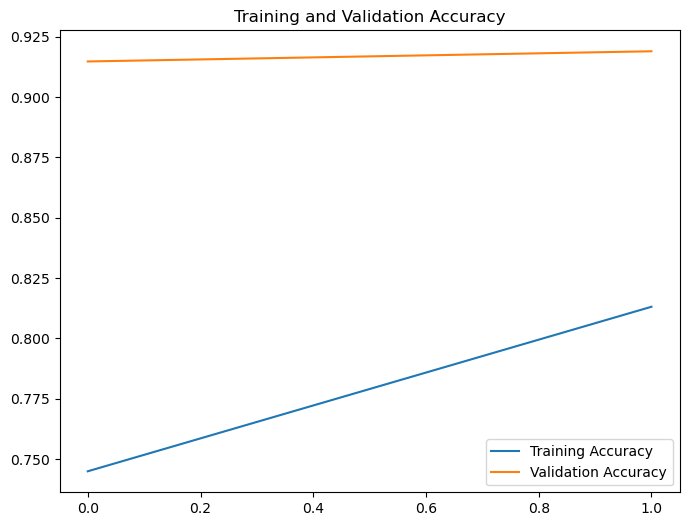

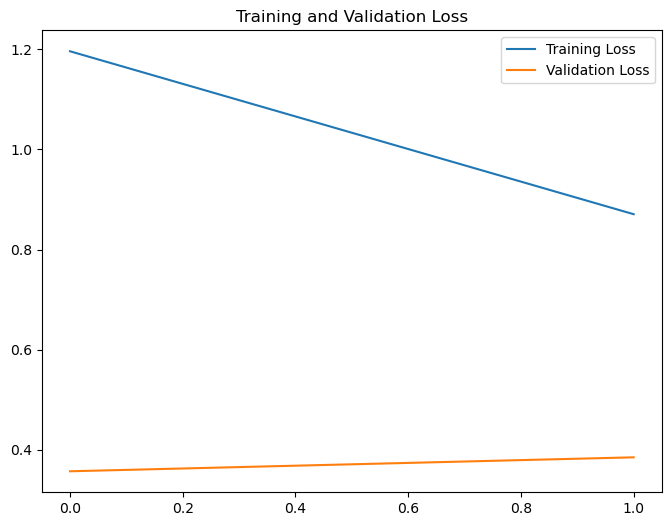

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.0203 - loss: 4.6510 - val_accuracy: 0.0303 - val_loss: 4.3428
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.0290 - loss: 4.4377 - val_accuracy: 0.0299 - val_loss: 4.3202
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.0334 - loss: 4.3528 - val_accuracy: 0.0445 - val_loss: 4.2646
Epoch 4/10
 76/161 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.0386 - loss: 4.3294

In [ ]:
train('inceptionresnetv2')

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 581s 4s/step - accuracy: 0.0209 - loss: 4.5925 - val_accuracy: 0.0345 - val_loss: 4.3450
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 457s 3s/step - accuracy: 0.0296 - loss: 4.4039 - val_accuracy: 0.0434 - val_loss: 4.3471


Model saved to: C:\Users\josej\Thesis\models\resnet50.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\resnet50.h5 (HDF5 format)


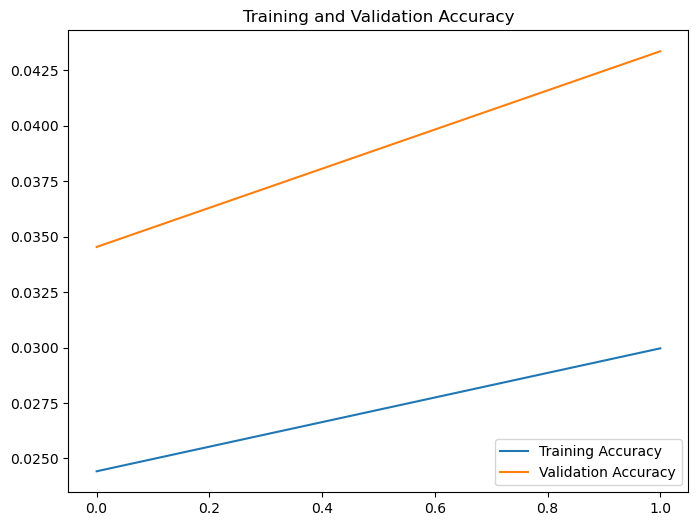

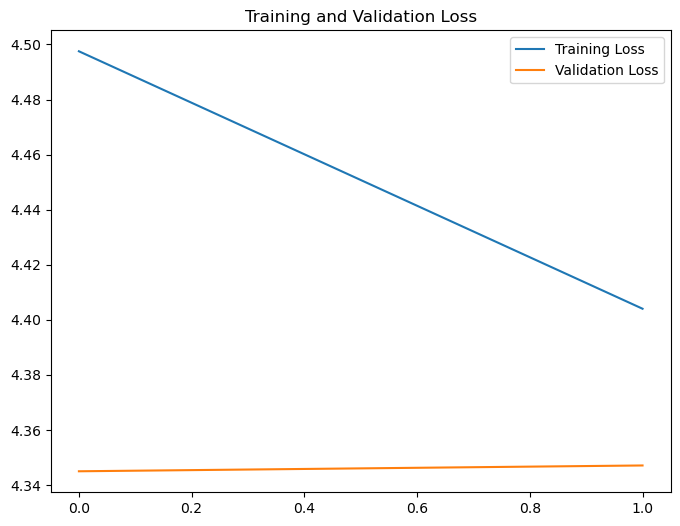

In [4]:
train('resnet50')

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.5201 - loss: 2.3290 - val_accuracy: 0.8791 - val_loss: 0.4812
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.7660 - loss: 1.0218 - val_accuracy: 0.8910 - val_loss: 0.4395
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 871s 5s/step - accuracy: 0.7784 - loss: 0.9478 - val_accuracy: 0.8903 - val_loss: 0.5224


Model saved to: C:\Users\josej\Thesis\models\inceptionv3.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\inceptionv3.h5 (HDF5 format)


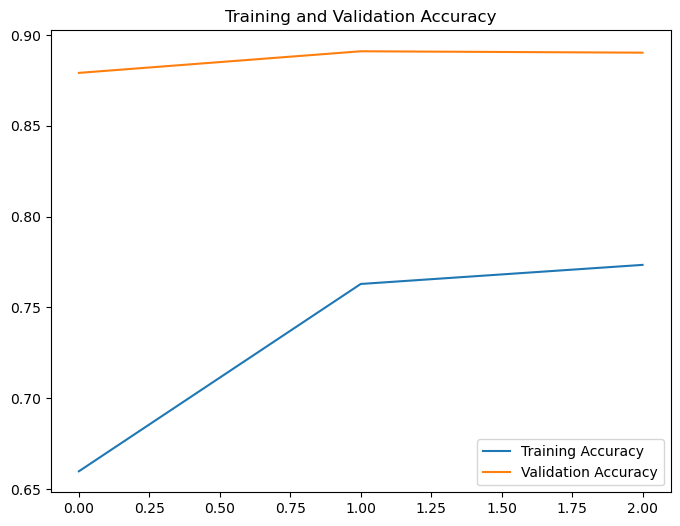

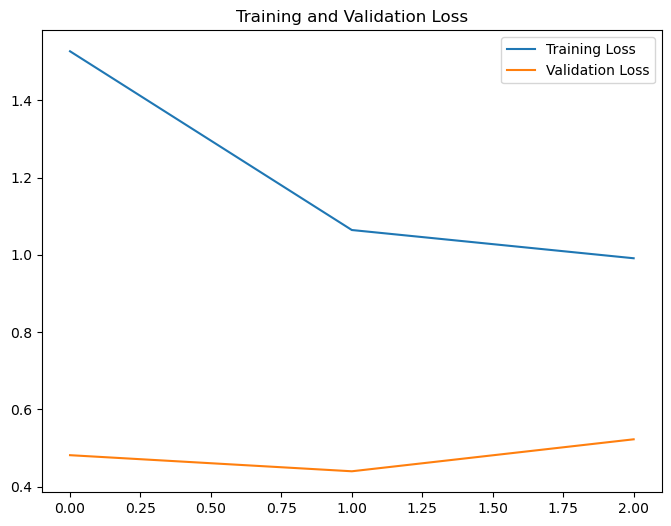

In [4]:
train('inceptionv3')

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 1736s 10s/step - accuracy: 0.6004 - loss: 1.7138 - val_accuracy: 0.8626 - val_loss: 0.5174
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1904s 12s/step - accuracy: 0.7879 - loss: 0.8498 - val_accuracy: 0.8684 - val_loss: 0.5188


Model saved to: C:\Users\josej\Thesis\models\xception.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\xception.h5 (HDF5 format)


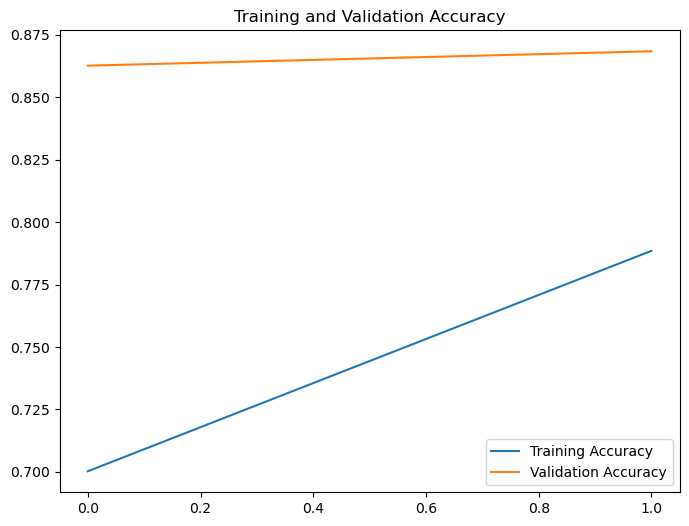

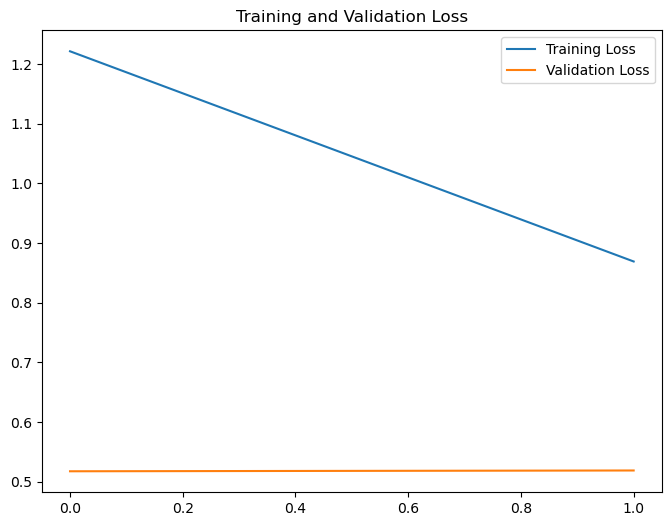

In [5]:
train('xception')

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 1908s 11s/step - accuracy: 0.3052 - loss: 3.3869 - val_accuracy: 0.7744 - val_loss: 0.7451
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1137s 7s/step - accuracy: 0.6910 - loss: 1.1135 - val_accuracy: 0.8093 - val_loss: 0.6254
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.7443 - loss: 0.9119 - val_accuracy: 0.8285 - val_loss: 0.5819
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.7677 - loss: 0.8133 - val_accuracy: 0.8446 - val_loss: 0.5661
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.7920 - loss: 0.7499 - val_accuracy: 0.8411 - val_loss: 0.5969


Model saved to: C:\Users\josej\Thesis\models\densenet121.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\densenet121.h5 (HDF5 format)


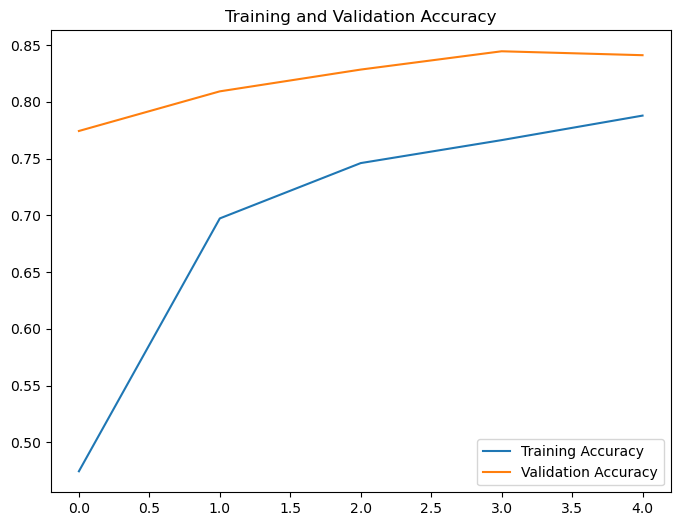

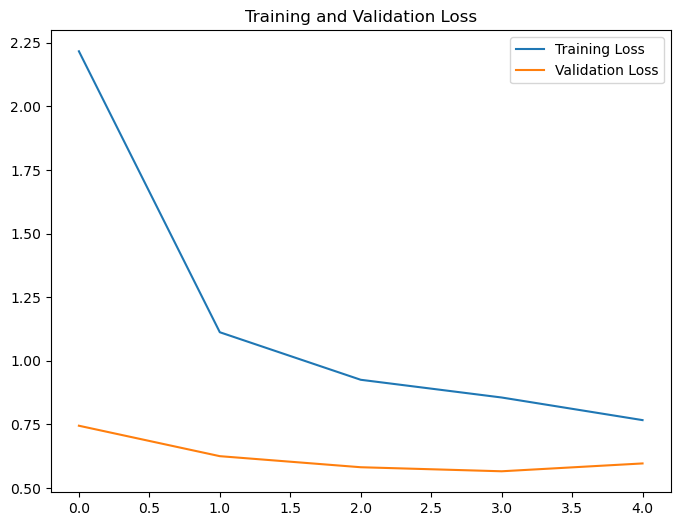

In [6]:
train('densenet121')

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 163s 969ms/step - accuracy: 0.3950 - loss: 2.9277 - val_accuracy: 0.7932 - val_loss: 0.7391
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 159s 968ms/step - accuracy: 0.6992 - loss: 1.2312 - val_accuracy: 0.8239 - val_loss: 0.6804
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 159s 968ms/step - accuracy: 0.7491 - loss: 1.0509 - val_accuracy: 0.8289 - val_loss: 0.6914


Model saved to: C:\Users\josej\Thesis\models\mobilenetv2.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\mobilenetv2.h5 (HDF5 format)


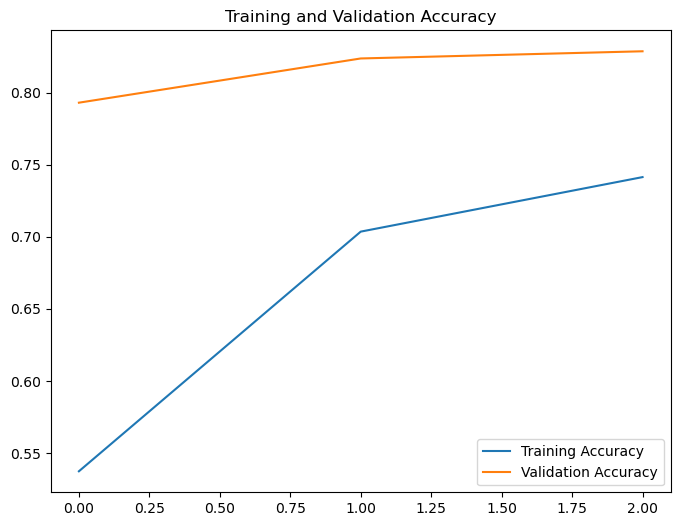

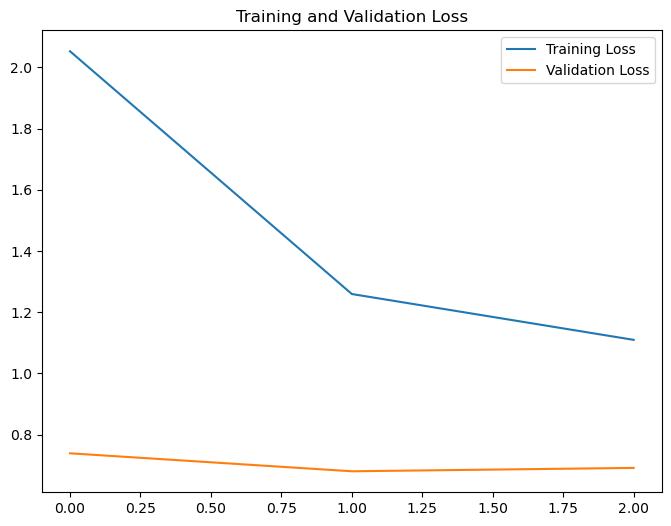

In [7]:
train('mobilenetv2')

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.5819 - loss: 1.9215 - val_accuracy: 0.9021 - val_loss: 0.3755
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8021 - loss: 0.7739 - val_accuracy: 0.8918 - val_loss: 0.4210


Model saved to: C:\Users\josej\Thesis\models\nasnetmobile.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\nasnetmobile.h5 (HDF5 format)


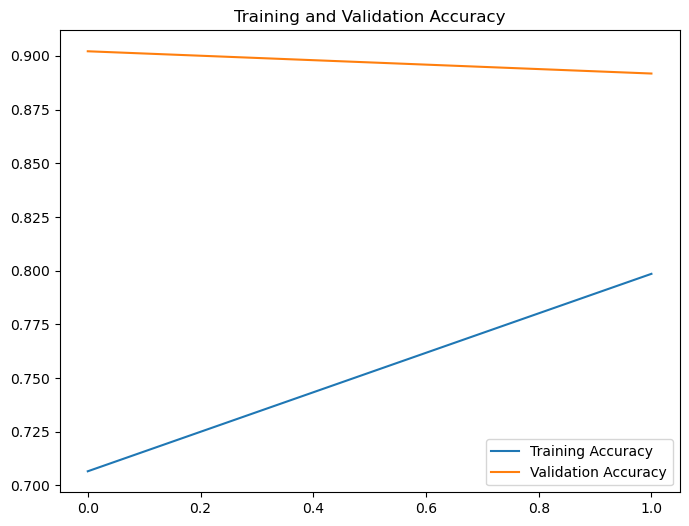

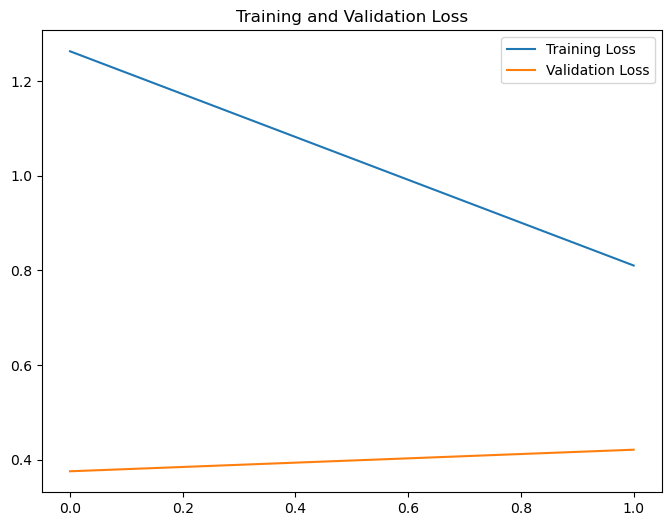

In [8]:
train('nasnetmobile')

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.0174 - loss: 4.6541 - val_accuracy: 0.0146 - val_loss: 4.5759
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.0126 - loss: 4.5823 - val_accuracy: 0.0169 - val_loss: 4.4738
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.0157 - loss: 4.5668 - val_accuracy: 0.0157 - val_loss: 4.5917


Model saved to: C:\Users\josej\Thesis\models\efficientnetb0.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\efficientnetb0.h5 (HDF5 format)


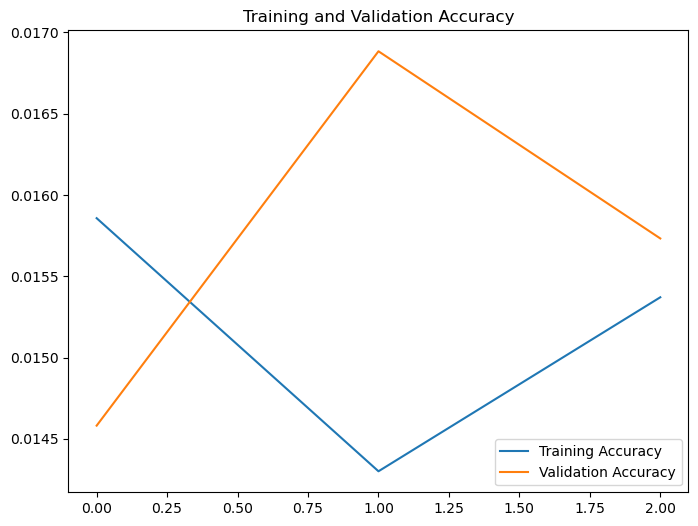

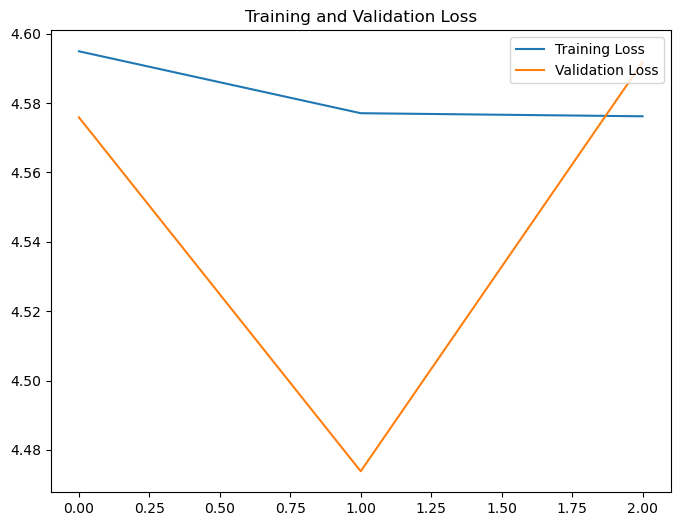

In [9]:
train('efficientnetb0')

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 842s 5s/step - accuracy: 0.0373 - loss: 4.2753 - val_accuracy: 0.1477 - val_loss: 3.6508
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 841s 5s/step - accuracy: 0.1374 - loss: 3.6983 - val_accuracy: 0.2168 - val_loss: 3.2434
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 841s 5s/step - accuracy: 0.2015 - loss: 3.3851 - val_accuracy: 0.2517 - val_loss: 3.0333
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 842s 5s/step - accuracy: 0.2280 - loss: 3.1998 - val_accuracy: 0.3047 - val_loss: 2.8521
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 843s 5s/step - accuracy: 0.2800 - loss: 2.9992 - val_accuracy: 0.3101 - val_loss: 2.6981
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 842s 5s/step - accuracy: 0.2982 - loss: 2.8867 - val_accuracy: 0.3427 - val_loss: 2.6120
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 842s 5s/step - accuracy: 0.3203 - loss: 2.7930 - val_accuracy: 0.3592 - val_loss: 2.5366
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 846s 5s/step - accuracy: 0.3328 - loss: 2.7286 - val_accuracy: 0.367

Model saved to: C:\Users\josej\Thesis\models\vgg16.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\vgg16.h5 (HDF5 format)


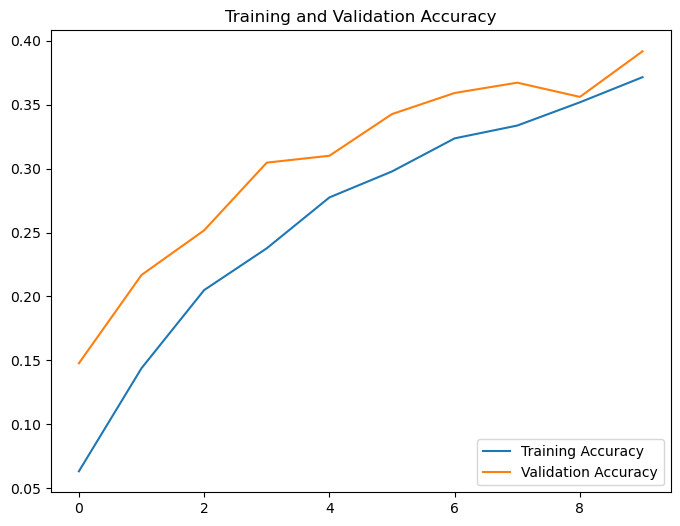

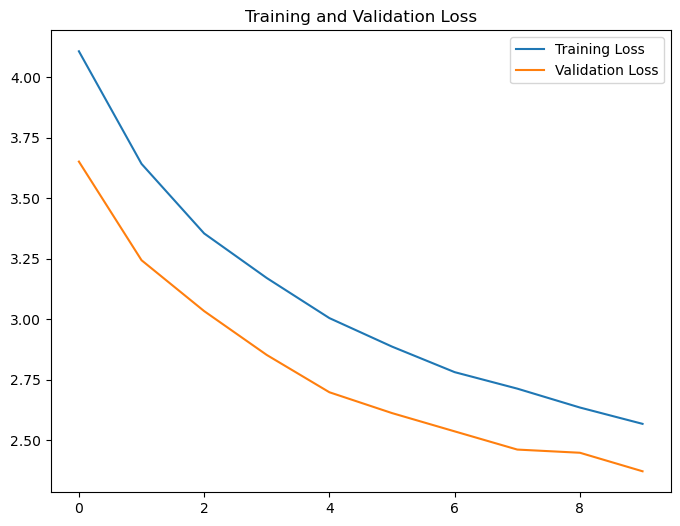

In [10]:
train('vgg16')

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 1064s 7s/step - accuracy: 0.0360 - loss: 4.3126 - val_accuracy: 0.1190 - val_loss: 3.7528
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1064s 7s/step - accuracy: 0.1162 - loss: 3.7993 - val_accuracy: 0.1734 - val_loss: 3.4126
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1062s 7s/step - accuracy: 0.1663 - loss: 3.5494 - val_accuracy: 0.2337 - val_loss: 3.1762
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1064s 7s/step - accuracy: 0.1956 - loss: 3.3349 - val_accuracy: 0.2586 - val_loss: 3.0416
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1064s 7s/step - accuracy: 0.2346 - loss: 3.1943 - val_accuracy: 0.2701 - val_loss: 2.9235
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1064s 7s/step - accuracy: 0.2540 - loss: 3.0965 - val_accuracy: 0.2847 - val_loss: 2.8459
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1066s 7s/step - accuracy: 0.2683 - loss: 2.9871 - val_accuracy: 0.3066 - val_loss: 2.7466
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 1064s 7s/step - accuracy: 0.2885 - loss: 2.9214 - val_accurac

Model saved to: C:\Users\josej\Thesis\models\vgg19.keras (Keras format)
Model saved to: C:\Users\josej\Thesis\models\vgg19.h5 (HDF5 format)


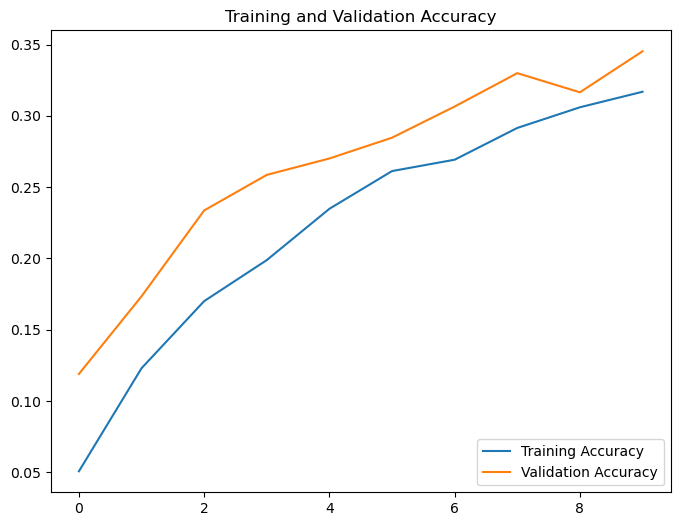

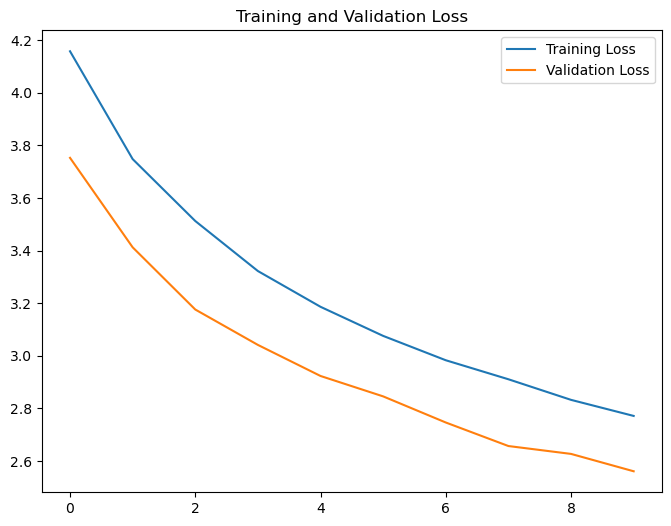

In [11]:
train('vgg19')